<a href="https://colab.research.google.com/github/FaisalAhmed0/machine_learning_from_scratch/blob/main/RNNs_for_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RNN Using pytorch


In [37]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import numpy as np

In [38]:
# Use GPU is avalible otherwise use cpu.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [39]:
# Define the RNN Module
class RNN(nn.Module):
  '''
  This class define a 'vanilla' RNN module
  Constructor parameters:
    input_dim = dimensionaltiy of the input.
    output_dim = dimensionaltiy of the output.
  '''
  def __init__(self, input_dim, output_dim):
    super().__init__()
    # each linear tranformation includes a bias term.
    self.linear_hh = nn.Linear(input_dim, output_dim, bias=True) # weights and baises for the hidden state
    self.linear_hx = nn.Linear(input_dim, output_dim, bias=True) # weights and baises for the input
    self.linear_hy = nn.Linear(input_dim, output_dim, bias=True) # weights and baises for the output

  # the forward pass will recive the input x_t and the previous hidden state h_{t-1}
  def forward(self, x, h):
    h = torch.tanh( self.linear_hh(h) + self.linear_hx(x))
    y = self.linear_hy(h)
    return y, h

In [40]:
def plot(loss, training_score, validation_score):
  '''
  helper method to plot the training dynamics.
  function parameters:
    loss: a list containing the training loss per epoch.
    training_score: a list containing the training evaluation score per epoch.
    validation_score: a list containing the validation evaluation score per epoch.
  '''
  iters = range(1, len(loss)+1)
  plt.figure()
  plt.plot(iters, loss)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Loss curve")

  plt.figure()
  plt.plot(iters, training_score, label="Training score")
  plt.plot(iters, validation_score, label="Validation score")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Score")



In [41]:
def onehot(idx, vocab_size):
  '''
  generate onehot vector given the key in the dictionary and the vocabulary size
  '''
  onehot_vec = torch.zeros(vocab_size)
  onehot_vec[idx] = 1
  return onehot_vec

In [42]:
# tranform the raw text to input, target pairs
def generate_examples(data, char_to_ix, ix_to_char):
  '''
  data: string that represent the text file
  char_to_idx: a dictionary that maps each unique charatcter to a unique index
  '''

  dataset = []
  vocab_size = len(char_to_ix)
  for i in range(len(data[:-1])):
    idx = char_to_ix[data[i]]
    target = char_to_ix[data[i+1]]
    dataset.append((onehot(idx, vocab_size), target))
  return dataset

In [44]:
def valid_splti(data, split_ratio=0.2):
  '''
  split the dataset into training and validation sets
  '''
  data_size = len(data)
  split = int (data_size * split_ratio)
  train = data[: data_size - split]
  valid = data[data_size - split: ]
  return train, valid

# Langauge modeling

In [45]:
# Training loop to train a langauge model
# if score_function is None, compute the accuracy
def train(model, criterion, input_seq, y_train ,valid_seq, y_valids ,optimizer, num_epochs):
    """
    This Method runs the optimization loop for learning the parameters, using truncated backpropegation through time
    Method parameters:
    model: the model object.
    criterion: the loss function.
    data_loader: training data loader object.
    valid_loader: validation data loader object.
    optmizer: the optimizer object.
    num_epochs: number of training epochs.
    The function returns: 
    losses: a list that containes the loss for every epoch.
    training_accuracies: a list that containes the traning accuracy for every epoch.
    validation_accuracies: a list that containes the validation accuracy for every epoch.
    """
    # Move model to the device (CPU or GPU).
    model = model.to(device)
    
    # Exponential moving average of the loss.
    ema_loss = None

    # Losses list 
    losses = []
    # training acuecay list
    training_accuracies = []
    # valid acuecay list
    validation_accuracies = []

    # length of the truncated seqeunce
    k = 100
    #inilize the hidden state to zero
    d = input_seq[0].shape

    seq_length = len(y_train)
    num_iteration = seq_length//k if seq_length % k == 0 else seq_length//k + 1
    print('----- Training Loop -----')
    # Loop over epochs.
    # TODO: put this inside an epoch loop, for now this is only a one epoch
    for epoch in range(num_epochs):
      correct = 0
      k_current = 0
      h = torch.zeros(d)
      for i in range(num_iteration):
        # print(f"iteration {i}, correct: {correct}")
        loss = 0
        # print(loss)
        # Make sure model is in training mode.
        model.train()   
        # Loop over k elemnt in the seqeunce for the forward pass
        h = h.detach() # detach the hidden state from the previos timesteps
        while (k_current+1)%k != 0 and k_current < len(y_train):
          # print(f"here k is {k_current}") 
          x_i = input_seq[k_current]
          y_i = y_train[k_current]
          output, h = model(torch.unsqueeze(x_i.to(device), dim=0), h.to(device))
          # print(output)
          # print(h)
          # print(y_i)
          # Compute the training accuracy
          with torch.no_grad():
            pred = output.argmax(dim=1, keepdim=True)
            # print(pred)
            # print(y_i)
            # Count number of correct predictions.
            correct += (pred.item() == y_i)
            # print(f"correct: {correct}, pred :{pred}, label: {y_i}, k_current:{k_current}")

          loss += criterion(output,  torch.tensor([y_i], device=device))
          k_current += 1

        k_current += 1
        if k_current < len(y_train):
          # print(f"here k is {k_current}")
          x_i = input_seq[k_current]
          y_i = y_train[k_current]
          output, h = model(torch.unsqueeze(x_i.to(device), dim=0), h.to(device))
          # print(output)
          # print(h)
          # print(y_i)
          # Compute the training accuracy
          with torch.no_grad():
            pred = output.argmax(dim=1, keepdim=True)
            # print(pred)
            # print(y_i)
            # Count number of correct predictions.
            correct += (pred.item() == y_i)
            # print(f"correct: {correct}, pred :{pred}, label: {y_i}, k_current:{k_current}")

          loss += criterion(output,  torch.tensor([y_i], device=device))
        
        # Backward pass
        if loss != 0:
          optimizer.zero_grad()
          loss /= k
          # print(f" k is {k_current}")
          loss.backward()
          optimizer.step()
        
      # NOTE: It is important to call .item() on the loss before summing.
      if ema_loss is None:
          ema_loss = loss.item()
      else:
          ema_loss += (loss - ema_loss) * 0.01
      
      train_score = 100. * correct / seq_length # training score

      # Compute the validation accuracy
      model.eval()  # switch to evaliation mode
      h = torch.zeros(d)
      correct = 0
      valid_seq_len = len(y_valids)
      with torch.no_grad():
        for x_valid, y_valid in zip(valid_seq, y_valids):
          output, h = model(x_valid.to(device), h.to(device))
          pred = output.argmax(dim=0)
          # Count number of correct predictions.
          correct += (pred.cpu().item() == y_valid)
      valid_score = 100. * correct / valid_seq_len # validation score
      
      losses.append(ema_loss)
      training_accuracies.append(train_score)
      validation_accuracies.append(valid_score)
      # print(ema_loss)
      print('Epoch: {} \tLoss: {:.12f} \tTraining Accuracy: {:.12f} \t Validation Accuracy: {:.12f}'.format(epoch, ema_loss, train_score, valid_score),)

    return losses, training_accuracies, validation_accuracies

In [46]:
# Load the data
# These lines are copied from https://gist.github.com/karpathy/d4dee566867f8291f086
# data I/O
def getData(filepath):
  '''
  given the file-path the will return the raw text as a string in the variable 'data', and two dictionaries:
  char_to_ix: maps a unique character to a unique index.
  ix_to_char: maps the index back to its character.
  '''
  data = open(filepath, 'r').read() # should be simple plain text file
  chars = list(set(data))
  data_size, vocab_size = len(data), len(chars)
  print ('data has %d characters, %d unique.' % (data_size, vocab_size))
  char_to_ix = { ch:i for i,ch in enumerate(chars) }
  ix_to_char = { i:ch for i,ch in enumerate(chars) }
  return data, char_to_ix, ix_to_char

In [47]:
# Tranform the row text to a training dataset
filepath = "input.txt"
data, char_to_ix, ix_to_char = getData(filepath)
dataset = generate_examples(data, char_to_ix, ix_to_char)

data has 79835 characters, 73 unique.


In [49]:
# split into training and validation 
train_set, validation_set = valid_splti(dataset, 0.001)

In [50]:
# split the inputs and the outputs
x_train, y_train, x_valid, y_valid = [], [], [], []
for x, y in train_set:
  x_train.append(x)
  y_train.append(y)
for x, y in validation_set:
  x_valid.append(x)
  y_valid.append(y)

In [51]:
# Define the model
lr = 1e-3 # learning rate
epochs = 500 # number of epochs
rnn = RNN(73, 73) 
criterion = torch.nn.CrossEntropyLoss() # loss function
optimizer = optim.Adam(rnn.parameters(), lr=lr) # optimizer

In [52]:
# fit the model
loss, train_socre, valid_score = train(rnn, criterion, x_train, y_train, x_valid, y_valid, optimizer, epochs)

----- Training Loop -----
Epoch: 0 	Loss: 1.405218243599 	Training Accuracy: 26.190207510501 	 Validation Accuracy: 35.443037974684
Epoch: 1 	Loss: 1.404169201851 	Training Accuracy: 36.538148078490 	 Validation Accuracy: 32.911392405063
Epoch: 2 	Loss: 1.402511954308 	Training Accuracy: 41.290201241301 	 Validation Accuracy: 37.974683544304
Epoch: 3 	Loss: 1.400360941887 	Training Accuracy: 45.045451695818 	 Validation Accuracy: 43.037974683544
Epoch: 4 	Loss: 1.397731065750 	Training Accuracy: 47.553131465112 	 Validation Accuracy: 43.037974683544
Epoch: 5 	Loss: 1.394677996635 	Training Accuracy: 49.497837126199 	 Validation Accuracy: 44.303797468354
Epoch: 6 	Loss: 1.391263604164 	Training Accuracy: 50.959814431697 	 Validation Accuracy: 46.835443037975
Epoch: 7 	Loss: 1.387531757355 	Training Accuracy: 52.425553256849 	 Validation Accuracy: 45.569620253165
Epoch: 8 	Loss: 1.383507728577 	Training Accuracy: 53.738323616074 	 Validation Accuracy: 49.367088607595
Epoch: 9 	Loss: 1.37

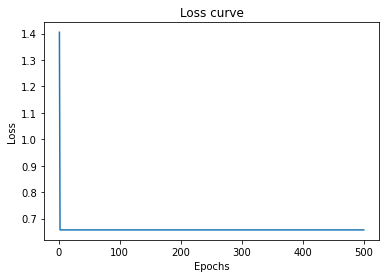

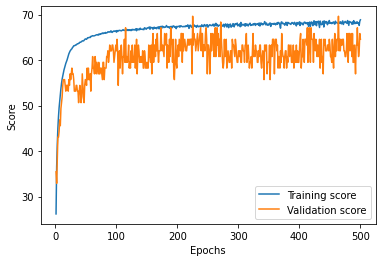

In [53]:
# plot the training dynamcis
plot(loss, train_socre, valid_score)

In [54]:
# generate some text given the model and an initial chatacter, vocab_size, and the text length
def generate_text(model, init, d, seq_length):
  char = init
  idx = char_to_ix[char]
  h = torch.zeros(d)
  txt = []
  txt.append(char)
  with torch.no_grad():
    for _ in range(seq_length):
      inp = onehot(idx, d)
      # print(inp)
      y, h = model(torch.unsqueeze(inp, dim=0).to(device), h.to(device))
      probs = F.softmax(y, dim=1).cpu().numpy()[0]
      idx =  np.random.choice(d, 1, p=probs)[0] # sample from the output disrbution
      txt.append(ix_to_char[idx])
  return "".join(txt)

In [55]:
"".join(txt)

'ThAs byithey dibleder hoges that arally have of the brain, the exply that she gruncings; of the intere protwjee, is as the solidide in a werld, achion an un the brain’ gious the relucad pretantstince causal byothem.\nNow, tous pretantes. Nowevion for how the burally in these liveln with le\nthat notrence\nstath for a micro-sysiatilick all in ortich hecouratk is to a\npoinge nerd in paislar ammoust is to\nde bean brtwatitus eft that is compotst lifectlaine it they arfic of the that bray that have a cer'